In [28]:
import numpy as np
import pickle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD
from keras.utils import np_utils

In [2]:
METHOD = 'cnn_self-training-add-part_experiment'

LABELLED_DATA_FILE = 'data/all_label.p'
UNLABELED_DATA_FILE = 'data/all_unlabel.p'
TEST_DATA_FILE = 'data/test.p'

OUTPUT_FOLDER = 'output/'
MODEL_FOLDER = 'model/' + METHOD + '/'

In [3]:
import os
if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# Train

### Loading Training Data

In [4]:
labelled_data = np.array(pickle.load(open(LABELLED_DATA_FILE, 'rb')))
unlabeled_data = np.array(pickle.load(open(UNLABELED_DATA_FILE, 'rb')))

In [5]:
nb_classes = 10
img_rows, img_cols, img_channels = 32, 32, 3

In [6]:
# generate x, y from data

# reshape labelled data to (5000, 3, 32, 32)
X_train_label = labelled_data.reshape((5000, img_channels, img_rows, img_cols)).astype('float32') / 255

# reshape unlabeled data to (45000, 3, 32, 32)
X_train_unlabel = unlabeled_data.reshape((unlabeled_data.shape[0], img_channels, img_rows, img_cols)).astype('float32') / 255

y_train_label_class = np.array([classIdx for classIdx in range(len(labelled_data)) for i in range(len(labelled_data[classIdx]))])
Y_train_label = np_utils.to_categorical(y_train_label_class, nb_classes)

In [13]:
# TODO: remove

from keras.datasets import cifar10

(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = cifar10.load_data()

# X_train_reshaped = np.array([[img[:, :, 0], img[:, :, 1], img[:, :, 2]] for img in X_train]) / 255.0
X_test_cifar = np.array([[img[:, :, 0], img[:, :, 1], img[:, :, 2]] for img in X_test_cifar]) / 255.0
Y_test_cifar = np_utils.to_categorical(y_test_cifar.flatten(), 10)

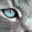

In [8]:
# visualize
from scipy.misc import toimage
toimage(X_train_unlabel[5])

### Training

In [9]:
from scipy.stats import entropy

def certainty(prob_arr):  # higher is more certain
    return -entropy(prob_arr)

def uncertainty(prob_arr):  # lower is better. for descending-ordered sorting
    return entropy(prob_arr)

#     sorted_arr = np.sort(prob_arr)
#     return sorted_arr[-1] / sorted_arr[-2]

#### First model

In [ ]:
# first model
batch_size = 64
nb_epoch = 100

model = Sequential()

model.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=X_train_label.shape[1:], dim_ordering="th"))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(0.5))

# model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th"))
# model.add(Activation('relu'))
# # model.add(Convolution2D(64, 3, 3))
# # model.add(Activation('relu'))
# model.add(AveragePooling2D(pool_size=(2, 2), dim_ordering="th", border_mode='same'))
# model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th"))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th"))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), dim_ordering="th", border_mode='same'))
model.add(Dropout(0.5))

model.add(Flatten())  # n * 8 * 8, for 64 -> 4096

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train_label, Y_train_label,
    batch_size=batch_size,
    nb_epoch=nb_epoch,  # nb_epoch,
    validation_data=(X_test_cifar, Y_test_cifar),
    shuffle=True)

model_1 = model

In [ ]:
model_name = (METHOD
    + '_first-model'
    + '_filters-64-48-512'
#     + '_add-0.25'
    + '_epo-100' # + str(nb_epoch)
    + '_0.39' # + str(val_acc)[:6]
)
model.save(MODEL_FOLDER + model_name)

In [68]:
# load model
model_name = 'model_second_6464MP6464APS512256128_extr45_epo23_acc9030_5436'
model = load_model('model/cnn_self-training-add-part_experiment/' + model_name)
model_1 = model

In [22]:
model_name

'cnn_self-training-add-part_experiment_second-model_filters-64-64-MP-48-MP-512_add-0.4_epo-70_acc0.8823_0.4868'

#### Second model

In [69]:
# use the model to label unlabeled data
Y_train_unlabel_proba = model.predict_proba(X_train_unlabel)  # same as model.predict
Y_train_unlabel_uncertainty = np.apply_along_axis(uncertainty, 1, Y_train_unlabel_proba)

Y_train_unlabel_class = model.predict_classes(X_train_unlabel)
Y_train_unlabel = np_utils.to_categorical(Y_train_unlabel_class, nb_classes)

# sort unlabeled data by uncertainty
sorted_idxs = Y_train_unlabel_uncertainty.argsort()
X_train_unlabel_sorted = X_train_unlabel[sorted_idxs]
Y_train_unlabel_sorted = Y_train_unlabel[sorted_idxs]

45000/45000 [==============================] - 6s     


In [70]:
extract_ratio = 0.45

# extract high-certainty unlabeled data
nb_extract = int(X_train_unlabel.shape[0] * extract_ratio)
X_train_unlabel_certain, X_train_unlabel_uncertain = X_train_unlabel_sorted[:nb_extract], X_train_unlabel_sorted[nb_extract:]
Y_train_unlabel_certain, Y_train_unlabel_uncertain = Y_train_unlabel_sorted[:nb_extract], Y_train_unlabel_sorted[nb_extract:]

# update labelled dataset and unlabeled dataset
X_train_label_pool = np.concatenate((X_train_label, X_train_unlabel_certain))
Y_train_label_pool = np.concatenate((Y_train_label, Y_train_unlabel_certain))
X_train_unlabel_pool = X_train_unlabel_uncertain
Y_train_unlabel_pool = Y_train_unlabel_uncertain

In [71]:
# second model

model = Sequential()

model.add(Convolution2D(128, 3, 3, border_mode='same', input_shape=X_train_label.shape[1:], dim_ordering="th"))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', dim_ordering="th"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(0.5))

# model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th"))
# model.add(Activation('relu'))
# # model.add(Convolution2D(64, 3, 3))
# # model.add(Activation('relu'))
# model.add(AveragePooling2D(pool_size=(2, 2), dim_ordering="th", border_mode='same'))
# model.add(Dropout(0.5))

model.add(Convolution2D(128, 3, 3, border_mode='same', dim_ordering="th"))
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', dim_ordering="th"))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), dim_ordering="th", border_mode='same'))
model.add(Dropout(0.5))

model.add(Flatten())  # n * 8 * 8, for 64 -> 4096

model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [98]:
batch_size = 64
nb_epoch = int(500000 / X_train_label_pool.shape[0])

model.fit(X_train_label_pool, Y_train_label_pool,
    batch_size=batch_size,
    nb_epoch=1,  # nb_epoch,
    validation_data=(X_test_cifar, Y_test_cifar),
    shuffle=True)

Train on 25250 samples, validate on 10000 samples
Epoch 1/1
25250/25250 [==============================] - 25s - loss: 0.1663 - acc: 0.9503 - val_loss: 2.0330 - val_acc: 0.5590


In [40]:
# model_second_6464MP6464APS512256128_extr45_epo23_acc8944_5280 = model

In [99]:
# model_name = (METHOD
#     + '_second-model'
#     + '_filters-64-64-MP-64-64--512'
#     + '_add-0.4'
#     + '_epo-70' # + str(nb_epoch)
#     + '_acc0.8823_0.4868' # + str(val_acc)[:6]
# )
model_name = "model_third_128128MP128128APS1024256128_extr45_epo30_acc9457_5590"
model.save(MODEL_FOLDER + model_name)

In [62]:
# load model
model_name = 'cnn_self-training-add-part_experiment_second-model_filters-64-64-MP-48-MP-512_add-0.4_epo-70_acc0.8823_0.4868'
model = load_model('model/cnn_self-training-add-part_experiment/' + model_name)

model_2 = model

####  Third model

In [54]:
# use the model to label unlabeled data
Y_train_unlabel_proba = model.predict_proba(X_train_unlabel)  # same as model.predict
Y_train_unlabel_uncertainty = np.apply_along_axis(uncertainty, 1, Y_train_unlabel_proba)

Y_train_unlabel_class = model.predict_classes(X_train_unlabel)
Y_train_unlabel = np_utils.to_categorical(Y_train_unlabel_class, nb_classes)

# sort unlabeled data by uncertainty
sorted_idxs = Y_train_unlabel_uncertainty.argsort()
X_train_unlabel_sorted = X_train_unlabel[sorted_idxs]
Y_train_unlabel_sorted = Y_train_unlabel[sorted_idxs]

44992/45000 [============================>.] - ETA: 0s

In [55]:
extract_ratio = 0.5

# extract high-certainty unlabeled data
nb_extract = int(X_train_unlabel.shape[0] * extract_ratio)
X_train_unlabel_certain, X_train_unlabel_uncertain = X_train_unlabel_sorted[:nb_extract], X_train_unlabel_sorted[nb_extract:]
Y_train_unlabel_certain, Y_train_unlabel_uncertain = Y_train_unlabel_sorted[:nb_extract], Y_train_unlabel_sorted[nb_extract:]

# update labelled dataset and unlabeled dataset
X_train_label_pool = np.concatenate((X_train_label, X_train_unlabel_certain))
Y_train_label_pool = np.concatenate((Y_train_label, Y_train_unlabel_certain))
X_train_unlabel_pool = X_train_unlabel_uncertain
Y_train_unlabel_pool = Y_train_unlabel_uncertain

In [56]:
# third model

model = Sequential()

model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th", input_shape=X_train_label.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(0.5))

# model.add(Convolution2D(32, 3, 3, border_mode='same', dim_ordering="th"))
# model.add(Activation('relu'))
model.add(Convolution2D(48, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [78]:
batch_size = 64
nb_epoch = int(500000 / X_train_label_pool.shape[0])

model.fit(X_train_label_pool, Y_train_label_pool,
    batch_size=batch_size,
    nb_epoch=1,  # nb_epoch,
    validation_data=(X_test_cifar, Y_test_cifar),
    shuffle=True)

Train on 27500 samples, validate on 10000 samples
Epoch 1/1
27500/27500 [==============================] - 13s - loss: 0.2040 - acc: 0.9295 - val_loss: 2.3113 - val_acc: 0.4210


In [77]:
model_name = (METHOD
    + '_third-model'
    + '_filters-64-64-MP-48-MP-512'
    + '_add-0.5'
    + '_epo-50' # + str(nb_epoch)
    + '_acc0.9203_0.48' # + str(val_acc)[:6]
)
model.save(MODEL_FOLDER + model_name)

In [ ]:
# use the model to label unlabeled data
Y_train_unlabel_proba = model.predict_proba(X_train_unlabel_pool)  # same as model.predict
Y_train_unlabel_uncertainty = np.apply_along_axis(uncertainty, 1, Y_train_unlabel_proba)

Y_train_unlabel_class = model.predict_classes(X_train_unlabel_pool, batch_size=10000)
Y_train_unlabel = np_utils.to_categorical(Y_train_unlabel_class, nb_classes)

# sort unlabeled data by uncertainty
sorted_idxs = Y_train_unlabel_uncertainty.argsort()
X_train_unlabel_sorted = X_train_unlabel_pool[sorted_idxs]
Y_train_unlabel_sorted = Y_train_unlabel_pool[sorted_idxs]

In [ ]:
extract_ratio = 0.2

# extract high-certainty unlabeled data
nb_extract = int(X_train_unlabel.shape[0] * extract_ratio)
X_train_unlabel_certain, X_train_unlabel_uncertain = X_train_unlabel_sorted[:nb_extract], X_train_unlabel_sorted[nb_extract:]
Y_train_unlabel_certain, Y_train_unlabel_uncertain = Y_train_unlabel_sorted[:nb_extract], Y_train_unlabel_sorted[nb_extract:]

# update labelled dataset and unlabeled dataset
X_train_label_pool_2 = np.concatenate((X_train_label, X_train_unlabel_certain))
Y_train_label_pool_2 = np.concatenate((Y_train_label, Y_train_unlabel_certain))
X_train_unlabel_pool_2 = X_train_unlabel_uncertain
Y_train_unlabel_pool_2 = Y_train_unlabel_uncertain

In [ ]:
# set model

def reset_model():

    model = Sequential()

    model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th", input_shape=X_train_label.shape[1:]))
    model.add(Activation('relu'))
#     model.add(Convolution2D(32, 3, 3))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same', dim_ordering="th"))
    model.add(Dropout(0.5))

    model.add(Convolution2D(32, 3, 3, border_mode='same', dim_ordering="th"))
    model.add(Activation('relu'))
#     model.add(Convolution2D(64, 3, 3))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same', dim_ordering="th"))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
# avoid change to the original labelled data
X_train_ori_label = np.copy(X_train_label)
Y_train_ori_label = np.copy(Y_train_label)
X_train_ori_unlabel = np.copy(X_train_unlabel)

In [ ]:
extract_ratio = 0.25
nb_extract_rounds = 3

In [ ]:
# extract high-certainty labelled-unlabeled data and add to labelled dataset

# TODO: remove (X_test_reshaped, Y_test_categ),

for extract_round in range(nb_extract_rounds):
    print('extract_round:', extract_round+1)
    # reset model
    model = reset_model()
    
    # train model
    model.fit(X_train_label, Y_train_label,
        batch_size=batch_size,
        nb_epoch=nb_epoch,  # nb_epoch,
        validation_data=(X_test_reshaped, Y_test_categ),
        shuffle=True)

    # use the model to label unlabeled data
    Y_train_unlabel_proba = model.predict_proba(X_train_unlabel, batch_size=10000)  # same as model.predict
    Y_train_unlabel_uncertainty = np.apply_along_axis(uncertainty, 1, Y_train_unlabel_proba)
    
    Y_train_unlabel_class = model.predict_classes(X_train_unlabel, batch_size=10000)
    Y_train_unlabel = np_utils.to_categorical(Y_train_unlabel_class, nb_classes)

    # sort unlabeled data by uncertainty
    sorted_idxs = Y_train_unlabel_uncertainty.argsort()
    X_train_unlabel = X_train_unlabel[sorted_idxs]
    Y_train_unlabel = Y_train_unlabel[sorted_idxs]
    
    # extract high-certainty unlabeled data
    nb_extract = int(X_train_unlabel.shape[0] * extract_ratio)
    X_train_unlabel_certain, X_train_unlabel_uncertain = X_train_unlabel[:nb_extract], X_train_unlabel[nb_extract:]
    Y_train_unlabel_certain, Y_train_unlabel_uncertain = Y_train_unlabel[:nb_extract], Y_train_unlabel[nb_extract:]

    # update labelled dataset and unlabeled dataset
    X_train_label = np.concatenate((X_train_label, X_train_unlabel_certain))
    Y_train_label = np.concatenate((Y_train_label, Y_train_unlabel_certain))
    X_train_unlabel = X_train_unlabel_uncertain
    Y_train_unlabel = Y_train_unlabel_uncertain

In [ ]:
# set model

def reset_model_2():

    model = Sequential()

    model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th", input_shape=X_train_label.shape[1:]))
    model.add(Activation('relu'))
#     model.add(Convolution2D(64, 3, 3))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same', dim_ordering="th"))
    model.add(Dropout(0.5))

    model.add(Convolution2D(64, 3, 3, border_mode='same', dim_ordering="th"))
    model.add(Activation('relu'))
#     model.add(Convolution2D(64, 3, 3))
#     model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same', dim_ordering="th"))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
model_bak = model

model = reset_model_2()

# TODO: remove (X_test_reshaped, Y_test_categ),

model.fit(X_train_label, Y_train_label,
    batch_size=batch_size,
    nb_epoch=100,  # nb_epoch,
    validation_data=(X_test_reshaped, Y_test_categ),
    shuffle=True)

In [ ]:
Y_train_label_class_predict = model.predict_classes(X_train_ori_label, batch_size=5000)
val_acc = np.sum(Y_train_label_class_predict == y_train_label_class) / float(len(y_train_label_class))
val_acc

In [ ]:
model_name = (METHOD
    + '_filters-64w3d0.5-32w3d0.5-512'
#     + '_add-0.25'
    + '_epo-100' # + str(nb_epoch)
    + '_0.37' # + str(val_acc)[:6]
)
model.save(MODEL_FOLDER + model_name)

# Test

### Loading test data 

In [60]:
test_data = pickle.load(open(TEST_DATA_FILE, 'rb'))  # dict
X_test = np.array(test_data['data']).reshape((10000, 3, 32, 32)).astype('float32') / 255

### Predict

In [100]:
result = model.predict_classes(X_test)
csv_content = list(zip(test_data['ID'], result.tolist()))
np.savetxt(OUTPUT_FOLDER + model_name + ".csv", csv_content, fmt="%i", header="ID,class", comments="", delimiter=",")

10000/10000 [==============================] - 2s     


In [19]:
model_name

'cnn_self-training-add-part_experiment_second-model_filters-64-64-MP-48-MP-512_add-0.4_epo-70_acc0.8823_0.4868'

In [29]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [30]:
# X_train_reshaped = np.array([[img[:, :, 0], img[:, :, 1], img[:, :, 2]] for img in X_train])
X_test_reshaped = np.array([[img[:, :, 0], img[:, :, 1], img[:, :, 2]] for img in X_test]) / 255.0

In [16]:
Y_test_class_predict = model.predict_classes(X_test_cifar)
np.sum(Y_test_class_predict == y_test_cifar.flatten()) / len(y_test_cifar)

10000/10000 [==============================] - 1s     


0.48680000000000001

In [ ]:
Y_train_class_predict = model.predict_classes(X_train_reshaped, batch_size=10000)
np.sum(Y_train_class_predict == y_train.flatten()) / len(y_train)

In [ ]:
toimage(X_train_reshaped[2])

In [ ]:
Y_train_class_predict[:10]

In [ ]:
y_train[:10]

In [ ]:
toimage(X_train_reshaped[1])